#### Passo a Passo


Objetivo: Observar simulações no modelo da rede, e propor otimizações com base nos resultados.

base do codigo: stochastic_simulation.py

fonte: repositório do github da biblioteca WNTR

In [1]:

# Bibliotecas
import wntr
import pickle
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt

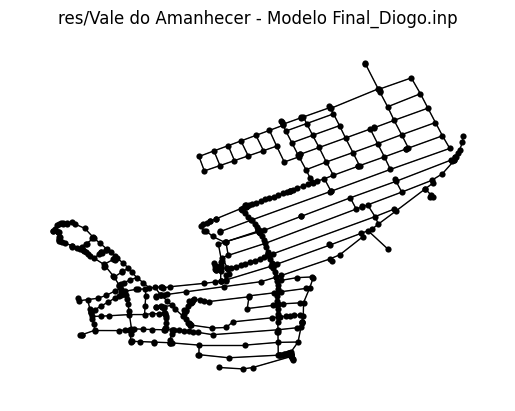

<AxesSubplot: title={'center': 'res/Vale do Amanhecer - Modelo Final_Diogo.inp'}>

In [2]:
# Criar ou importar modelo de rede de água
inp_file = 'res/Vale do Amanhecer - Modelo Final_Diogo.inp'
wn = wntr.network.WaterNetworkModel(inp_file)
# Gráfico da rede
wntr.graphics.plot_network(wn, title=wn.name)


In [3]:
# Fazer ajustes nas configurações do modelo, se necessário

wn.options.time.duration = 48*3600
wn.options.time.hydraulic_timestep = 1800
wn.options.time.report_timestep = 1800
wn.options.hydraulic.required_pressure = 15
wn.options.hydraulic.minimum_pressure = 0

Pipe Breaks: ['268' '588' '1' '343' '369'], Start Time: 5.6, End Time: 28.159999999999997
Pipe Breaks: ['205' '31' '516' '41' '401'], Start Time: 7.01, End Time: 25.79
Pipe Breaks: ['401' '251' '539' '43' '406'], Start Time: 9.85, End Time: 23.310000000000002
Pipe Breaks: ['558' '371' '577' '52' '556'], Start Time: 5.72, End Time: 21.63
Pipe Breaks: ['564' '510' '527' '248' '72'], Start Time: 8.67, End Time: 23.11


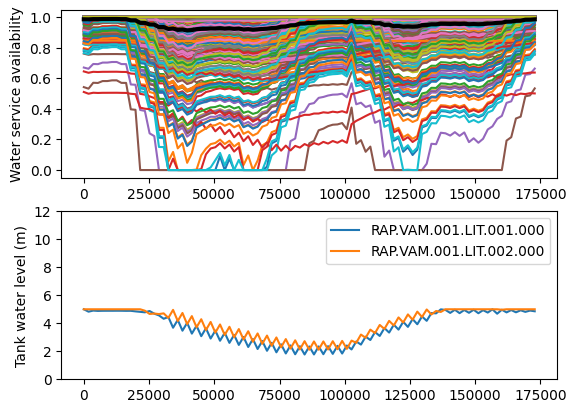

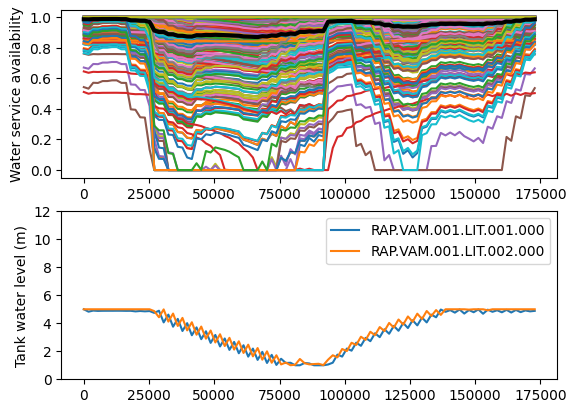

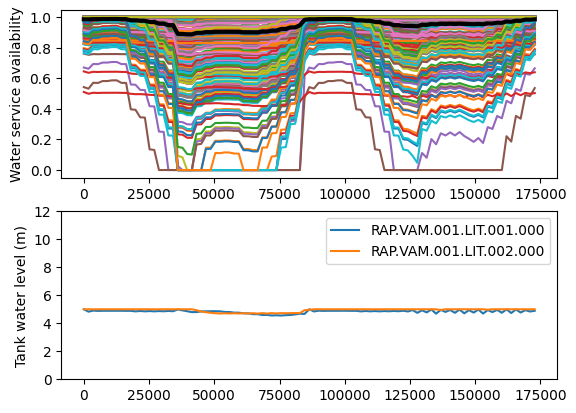

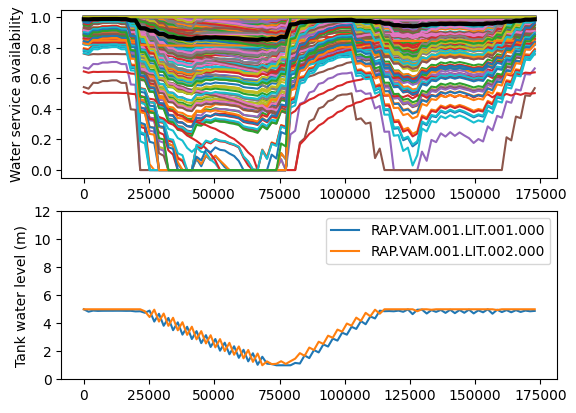

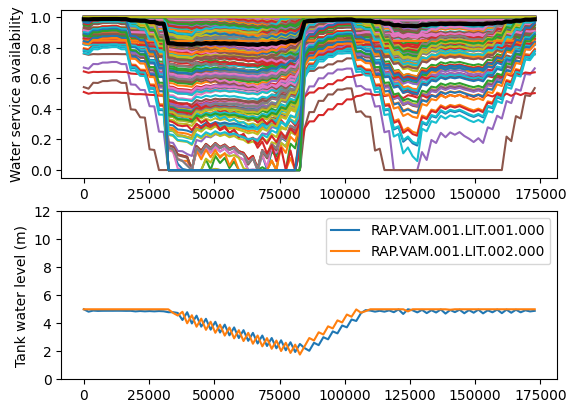

In [4]:
# Define a probabilidade de falha para cada cano, baseado em seu diâmetro.
# A probabilidade de falha soma em um total de 1.
#  Aqui usa-se o query_link_attribute para excluir canos com diametro igual a 99 polegadas
pipe_diameters = wn.query_link_attribute('diameter', np.less_equal,
                                         0.9144,  # 36 polegadas = 0.9144 m
                                         link_type=wntr.network.Pipe)
failure_probability = pipe_diameters/pipe_diameters.sum()

# Criptografa o modelo da rede com Pickle e recarrega para cada realização
f=open('output/wn.pickle','wb')
pickle.dump(wn,f)
f.close()

# Roda 5 realizações
results = {} # Initializa um dicionario para guardar os resultados
np.random.seed(67823) # Faz uma seed aleatória
for i in range(5):

    # Seleciona o numero de vazamentos, valor aleatório entre 1 e 5
    N = np.random.randint(1,6)

    # Seleciona N canos distintos baseado na probabilidade de falha
    pipes_to_fail = np.random.choice(failure_probability.index, 5,
                                     replace=False,
                                     p=failure_probability.values)

    # Seleciona o tempo da falha, dist uniforme, entre 1 e 10 horas
    time_of_failure = np.round(np.random.uniform(1,10,1)[0], 2)

    # Seleciona a duração da falha, dist uniforme, entre 12 e 24 horas
    duration_of_failure = np.round(np.random.uniform(12,24,1)[0], 2)
    
    # Adiciona os vazamentos ao modelo
    for pipe_to_fail in pipes_to_fail:
        pipe = wn.get_link(pipe_to_fail)
        leak_diameter = pipe.diameter*0.3
        leak_area=3.14159*(leak_diameter/2)**2
        wn = wntr.morph.split_pipe(wn, pipe_to_fail, pipe_to_fail + '_B', pipe_to_fail+'leak_node')
        leak_node = wn.get_node(pipe_to_fail+'leak_node')
        leak_node.add_leak(wn, area=leak_area,
                          start_time=time_of_failure*3600,
                          end_time=(time_of_failure + duration_of_failure)*3600)

    # Simula hidraulicas e salva os resultados
    wn.options.hydraulic.demand_model = 'PDD'
    sim = wntr.sim.WNTRSimulator(wn)
    print('Pipe Breaks: ' + str(pipes_to_fail) + ', Start Time: ' + \
                str(time_of_failure) + ', End Time: ' + \
                str(time_of_failure+duration_of_failure))
    results[i] = sim.run_sim()
    
    # Recarrega o modelo de rede de agua
    f=open('output/wn.pickle','rb')
    wn = pickle.load(f)
    f.close()

# Plota a availabilidade do serviço de agua e o nivel do tanque de água para cada realização
for i in results.keys():
    
    # Water service availability at each junction and time
    expected_demand = wntr.metrics.expected_demand(wn)
    demand = results[i].node['demand'].loc[:,wn.junction_name_list]
    wsa_nt = wntr.metrics.water_service_availability(expected_demand, demand)
    
    # Average water service availability at each time
    wsa_t = wntr.metrics.water_service_availability(expected_demand.sum(axis=1), 
                                                  demand.sum(axis=1))
                               
    # Tank water level
    tank_level = results[i].node['pressure'].loc[:,wn.tank_name_list]
    
    # Plot results
    plt.figure()
    
    plt.subplot(2,1,1)
    wsa_nt.plot(ax=plt.gca(), legend=False)
    wsa_t.plot(ax=plt.gca(), label='Average', color='k', linewidth=3.0, legend=False)
    plt.ylim( (-0.05, 1.05) )
    plt.ylabel('Water service availability')
    
    plt.subplot(2,1,2)
    tank_level.plot(ax=plt.gca())
    plt.ylim(ymin=0, ymax=12)
    plt.legend()
    plt.ylabel('Tank water level (m)')